#### **Import Libraries**

In [1]:
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import time 
import pandas as pd 
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DataCollatorWithPadding
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
import seaborn as sns 
import jax 
import jax.numpy as jnp 

#### **Set Up Paths**

In [2]:
data_csv = './../../../toy-data/exp2/results/combined_results.csv'
figures_folder = './../../../../instrumental_llms/figures/'

#### **Set Up Plotting**

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_14pt/Newsreader_14pt-Italic.ttf


#### **Process Data**

In [4]:
def process_dataframe(df, k):
    # Limit to the first 20 observations
    df = df.tail(k)
    
    # Drop rows where any column has an absolute value greater than 2
    df = df[df.apply(lambda x: (x.abs() <= 10).all(), axis=1)]
    return df

#### **Parameters**

In [5]:
version = 2
sample_size = 1000
noise = False
prompt = False

#### **LLM + NN**

In [6]:
df_llm_nn = pd.read_csv(f'./../../../toy-data/exp2/results/llm_nn_{version}_{sample_size}_{noise}.csv')
df_llm_nn = process_dataframe(df_llm_nn, 20)

#### **Neural Network**

In [7]:
df_nn = pd.read_csv(f'./../../../toy-data/exp2/results/nn_{version}_{sample_size}_{noise}.csv', header=None)
df_nn = process_dataframe(df_nn, 20)

#### **Linear Model**

In [8]:
df_linear= pd.read_csv(f'./../../../toy-data/exp2/results/linear_{version}_{sample_size}_{noise}.csv')
df_linear = process_dataframe(df_linear, 50)

In [9]:
print(jnp.std(df_llm_nn.values))
print(jnp.std(df_linear.values))
print(jnp.std(df_nn.values))

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Unable to load cuDNN. Is it installed?
Traceback (most recent call last):
  File "/home/ubuntu/llmft/llms/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 343, in _version_check
    version = get_version()
RuntimeError: cuDNN not found.
.(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


0.21903817
0.24098957
0.21371618


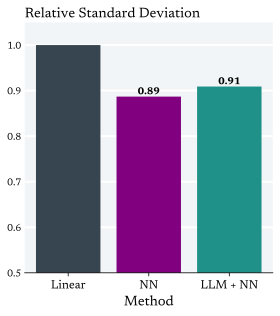

In [10]:
# Plot the bar chart
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Relative Standard Deviation', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
bars = plt.bar(range(3), [jnp.std(df_linear.values)/jnp.std(df_linear.values), jnp.std(df_nn.values)/jnp.std(df_linear.values),  jnp.std(df_llm_nn.values)/jnp.std(df_linear.values)], color=['#36454F', 'purple', '#1f9189'])

# Add titles and labels
plt.xlabel('Method', size=14)
plt.xticks(range(3), ['Linear', 'NN', 'LLM + NN'], fontsize=12)

# Adding data labels on top of each bar
for i, bar in enumerate(bars):
    if i > 0:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', weight='bold')
plt.ylim(0.5, 1.05)
fig.savefig(figures_folder + '/known_heterogeneity.png')
plt.show()